📁 Upload two images (query and scene):


Saving تصویر صفحه 2025-05-20 135541.png to تصویر صفحه 2025-05-20 135541 (1).png
Saving تصویر صفحه 2025-05-20 135556.png to تصویر صفحه 2025-05-20 135556 (1).png


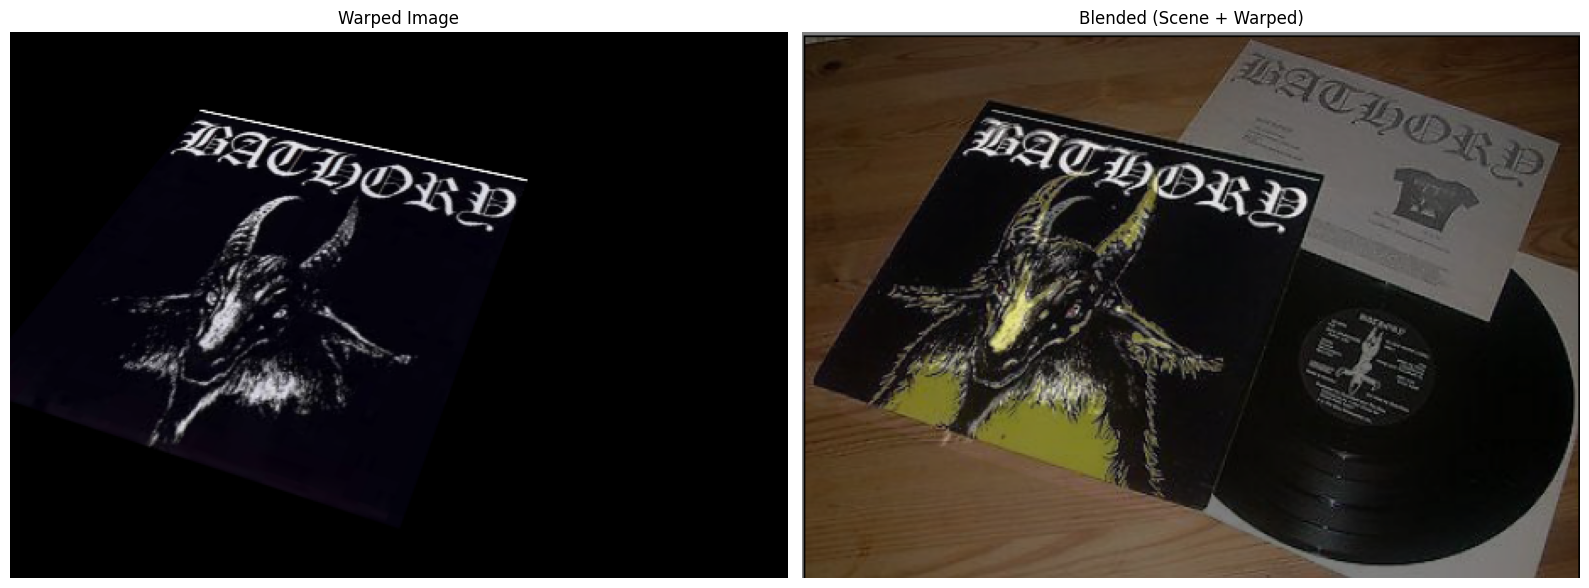

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files

# Step 1: Upload 2 images
print("📁 Upload two images (query and scene):")
uploaded = files.upload()
file_names = list(uploaded.keys())

if len(file_names) != 2:
    raise Exception("❗ Please upload exactly two images.")

# Step 2: Read as grayscale
img_query = cv2.imread(file_names[0], cv2.IMREAD_GRAYSCALE)
img_scene = cv2.imread(file_names[1], cv2.IMREAD_GRAYSCALE)

# Also read in color (for final drawing)
img_scene_color = cv2.imread(file_names[1])
img_query_color = cv2.imread(file_names[0])

# Step 3: SIFT keypoint detection
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_query, None)
kp2, des2 = sift.detectAndCompute(img_scene, None)

# Step 4: FLANN matcher + Lowe's ratio test
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

# Step 5: Homography estimation
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Step 6: Warp image using homography
    h, w = img_query.shape
    warped = cv2.warpPerspective(img_query_color, M, (img_scene.shape[1], img_scene.shape[0]))

    # Step 7: Combine warped image with the scene image
    blended = cv2.addWeighted(img_scene_color, 0.5, warped, 0.5, 0)

    # Step 8: Show result
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.title("Warped Image")
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Blended (Scene + Warped)")
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print(f"❗ Not enough matches found: {len(good)} / {MIN_MATCH_COUNT}")
